# Read tiles to input format VAE network

### Imports
Install tensorflow:
``%pip install tensorflow``

In [1]:
#%pip install tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
# tf.random.set_seed(2) 

In [3]:
from numpy.random import seed
seed(2)
# from tensorflow import set_random_seed
# set_random_seed(2)
tf.random.set_seed(2)

### Create sampling layer

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### Build encoder


In [5]:
latent_dim = 8 #2
filter_1 = 3 #32, 3
filter_2 = 2 #64, 2
kernel_size = 5 #3, 5
dense_size = 16; 
stride = 1; # 2 # when including maxpooling, use stride=1 ipv stride=2

encoder_inputs = keras.Input(shape=(20, 20,3)) # enter cut-out shape (20,20,3)

x = layers.Conv2D(filter_1, kernel_size, activation="relu", strides=stride, padding="same")(encoder_inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x) # add maxpooling layer

x = layers.Conv2D(filter_2, kernel_size, activation="relu", strides=stride, padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x) # add maxpooling layer

x = layers.Flatten()(x) # to vector
x = layers.Dense(dense_size, activation="relu")(x) # linked layer

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 20, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 3)    228         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 10, 10, 3)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 2)    152         max_pooling2d[0][0]              
____________________________________________________________________________________________

### Build decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(5 * 5 * filter_2, activation="relu")(latent_inputs) # -- shape corresponding to encoder
x = layers.Reshape((5, 5, filter_2))(x)

x = tf.keras.layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(filter_2, kernel_size, activation="relu", strides=stride, padding="same")(x)

x = tf.keras.layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(filter_1, kernel_size, activation="relu", strides=stride, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x) # (1,3) or (3,3)


decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                450       
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 2)           0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 2)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 2)         102       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 20, 20, 2)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 3)         153 

## Define VAE as model
With custom train_step

In [7]:
# Define VAE model.###################################### the whole cell has changed
outputs = decoder(z)
vae = tf.keras.Model(inputs=encoder_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
reconstruction = decoder(z)
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(
        keras.losses.binary_crossentropy(encoder_inputs, reconstruction), axis=(1, 2)
                )
            )
kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

alpha = 5

# Play witht different alpha: -2, 0 , 1 ,2 ; 0.2 ; -0.5 ; 50
# alpha = 10.; 
total_loss = reconstruction_loss +  alpha * kl_loss # alpha is custom
vae.add_loss(total_loss)

# Load labelled tile

In [8]:
import rioxarray
import xarray as xr
import numpy as np

Load 1 tile

In [9]:

dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
# imName = 'test_labelled_tile.tif'
imName = 'detailed_labelled_tile.tif'

In [10]:
tile = rioxarray.open_rasterio(dataPath + imName)
# tile.isnull().any()

Test: load coarse and detailed labeldata (on same tile)

In [11]:
from rioxarray.rioxarray import _add_attrs_proj
imName = 'test_labelled_tile.tif'
tile_coarse = rioxarray.open_rasterio(dataPath + imName)
imName = 'detailed_labelled_tile.tif'
tile_detail = rioxarray.open_rasterio(dataPath + imName)



In [12]:

labels_coarse = tile_coarse.isel(band=3)

tile = xr.concat([tile_detail,labels_coarse],'band') #band 4 = detailed-label, band 5=coarse-label

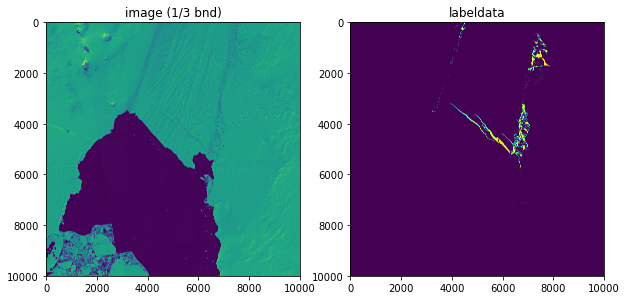

In [13]:

# imshow(amask[0])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
ax1.imshow(tile.isel(band=0))
ax1.set_title('image (1/3 bnd)'); 
ax2.imshow(tile.isel(band=3))
ax2.set_title('labeldata');

In [14]:
tile.attrs

{'scale_factor': 1.0, 'add_offset': 0.0, 'grid_mapping': 'spatial_ref'}

### Make cut-out with xarray rolling window

In [15]:
# initialise rolling object
rolling = tile.rolling(
    x=20,
    y=20,
)
rolling

DataArrayRolling [x->20,y->20]

In [16]:

cutouts = rolling.construct(
    {'x':'x_win', 'y': 'y_win'}, 
    stride={'x': 15, 'y': 15}, # windwo_listing uses 'overlap' of 5, which is a stride of 15 for a window of 20pixels
)

#### Reshape cut-outs 

from dataArray <xarray.DataArray (band: 4, y: 667, x: 667, x_win: 20, y_win: 20)>

to (n: 667*667 , x_win: 20, y_win: 20, bands: 4)

In [17]:
windowlist = cutouts.stack(sample=("y","x"))
windows = windowlist.transpose("sample","x_win","y_win","band")


In [18]:
windows.shape

(444889, 20, 20, 5)

#### issue: cutouts along the edge of the original raster are filled with NaN's - remove

In [19]:
windows.attrs["long_name"] = "bands"
# windows.isel(band=0, sample=0).plot.imshow()

In [20]:
# drop all NaN-containing cutouts - also useful if array has been masked with coastline shape
windows = windows.dropna(dim="sample", how="any")
windows.shape

(442225, 20, 20, 5)

### Make x_train and y_train
Test with fewer samples than in full dataset

In [21]:
x_train = windows[:,:,:,0:3]
y_train = windows[:,:,:,-1]
y_train = windows[:,:,:,-2:] # detailed&coarse label
print(x_train.shape,y_train.shape)

(442225, 20, 20, 3) (442225, 20, 20, 2)


#### Convert xarray.DataArray to numpy ndarray

In [22]:
x_train = x_train.values
y_train = y_train.values

### Normalise data

In [23]:
# print(x_train.max(),x_train.min())
# print(np.min(x_train),np.max(x_train))

In [24]:
imax = np.max(x_train) # 15.000-ish
x_train_norm = (x_train+0.1)/ (imax+1) 


In [25]:
print('0-values in data: ',np.any(x_train_norm == 0))
print('1-values in data: ',np.any(x_train_norm == 1))


0-values in data:  False
1-values in data:  False


### Process labels
Each window has a mask on pixel-basis. Convert this to label-per-window
- Sum all pixels in the window
- normalise the values to be 0-1: now we do not have binary label but range label, depending on fracture of window that is classified as crack.

In [26]:
y_train.shape

(442225, 20, 20, 2)

In [27]:
y_label = np.sum(y_train,axis=2)
y_label = np.sum(y_label,axis=1)
y_label.shape

(442225, 2)

In [28]:
len(y_label[np.where( y_label > 0 )]) # number of windows with label > 0
print(len(y_label[np.where( y_label > 0 )])/len(y_label))

0.03327943919950251


In [29]:
# print(np.min(y_label),np.max(y_label))
y_label_norm = (y_label)/ np.max(y_label) # normalise including 0,1 boundaries

# print(np.min(y_label_norm),np.max(y_label_norm))

print('N label > 0: {:.0f} out of {:.0f} '.format( np.sum(y_label_norm > 0) , len(y_label_norm)) )
print('Percentage of label>0 data: {:.1f}'.format( np.sum(y_label_norm > 0) / len(y_label_norm) * 100 ))

N label > 0: 14717 out of 442225 
Percentage of label>0 data: 3.3


Text(0.5, 1.0, 'hist of label>0')

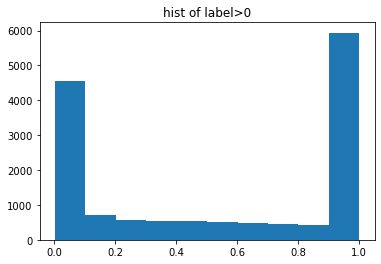

In [30]:
plt.figure
plt.hist(y_label_norm[y_label_norm > 0])
plt.title('hist of label>0')

##### Make binary mask

In [31]:
# y_label_norm[y_label_norm > 0] = 1
# y_label_norm.shape

# Train model

Make test-selection of data
Define balance of subset (i.e. 20% label > 0 , 80% label == 0, or 60/40 ratio or whatev)

In [32]:
def splitTrainTest(x_data,y_data,split): # split data to train&testing set, with same distribution of label 1/0 data
#     perc_test = 0.2; # 20% apart for training
    
    # select all samples with label>0
    L1_y = y_data[y_data > 0]
    L1_x = x_data[y_data > 0 , :,:,:]
    # select all samples with label == 0
    L0_y = y_data[y_data ==0]
    L0_x = x_data[y_data ==0 , :,:,:]

    # divide label>0 data to train/test: 
    idx1 = int((1-split) * len(L1_y))
    # divide label==0 data to train/test:
    idx0 = int((1-split) * len(L0_y))
    
    # merge label 0 and label 1 datasets for both a train&test set
    train_x = np.concatenate(( L0_x[:idx0,:,:,:] , L1_x[:idx1,:,:,:]))
    train_y = np.concatenate(( L0_y[:idx0] , L1_y[:idx1]))
    
    test_x = np.concatenate(( L0_x[idx0:,:,:,:] , L1_x[idx1:,:,:,:]))
    test_y = np.concatenate(( L0_y[idx0:] , L1_y[idx1:]))

    return train_x,train_y, test_x, test_y

# train_x, train_y, test_x , test_y = splitTrainTest( x_train_norm, y_label_norm[:,1], 0.2)
# print(x_train_norm.shape, train_x.shape, test_x.shape)

In [33]:
def makeBalancedSet(x_data,y_data,ratio): 
    # make data balanced to specified ratio, keeping all label>0 data and updating number of label=0 data
    
    # select all samples with label>0
    L1_y = y_data[y_data > 0]
    L1_x = x_data[y_data > 0 , :,:,:]
    # select all samples with label == 0
    L0_y = y_data[y_data ==0]
    L0_x = x_data[y_data ==0 , :,:,:]

    # select % of label=1 and label=0 data
    N1 = int(len(L1_y)) # number of label>0
    N0 = int(N1/ratio) # number of label==0 (in balance to label>0)
    
    # merge label 0 and label 1 datasets for both a train&test set
    x_data = np.concatenate(( L0_x[:N0,:,:,:] , L1_x[:N1,:,:,:]))
    y_data = np.concatenate(( L0_y[:N0] , L1_y[:N1]))

    return x_data,y_data


# x_train_balanced, y_train_balanced = makeBalancedSet( train_x, train_y, 40/60)
# x_test_balanced, y_test_balanced = makeBalancedSet( test_x, test_y, 40/60)


In [34]:
# print(train_x.shape, x_train_balanced.shape)
# print(test_x.shape, x_test_balanced.shape)

#### TMP: compare coarse/finegrained labels: Split both coarse and finegrained labels the same

In [73]:
y_data = y_label_norm[:,0] # 0=detailed, 1=coarse
x_data = x_train_norm;

split = 0.2;

# select all samples with label>0
# L1_y_detail = y_label_norm[y_data > 0,0]
# L1_y_coarse = y_label_norm[y_data > 0,1]
L1_y = y_label_norm[y_data > 0,:]
L1_x = x_data[y_data > 0 , :,:,:]

# select all samples with label == 0
# L0_y_detail = y_label_norm[y_data ==0,0]
# L0_y_coarse = y_label_norm[y_data ==0,1]
L0_y = y_label_norm[y_data==0,:]
L0_x = x_data[y_data ==0 , :,:,:]

# divide label>0 data to train/test: 
idx1 = int((1-split) * len(L1_y))
# divide label==0 data to train/test:
idx0 = int((1-split) * len(L0_y))

# merge label 0 and label 1 datasets for both a train&test set
train_x = np.concatenate(( L0_x[:idx0,:,:,:] , L1_x[:idx1,:,:,:]))
train_y = np.concatenate(( L0_y[:idx0] , L1_y[:idx1]))

test_x = np.concatenate(( L0_x[idx0:,:,:,:] , L1_x[idx1:,:,:,:]))
test_y = np.concatenate(( L0_y[idx0:,:] , L1_y[idx1:,:]))




In [74]:
def makeBalancedSet2(x_data,y_data,ratio): 
    # make data balanced to specified ratio, keeping all label>0 data and updating number of label=0 data
    
    # select all samples with label>0
    L1_y = y_data[y_data[:,0] > 0,:]
    L1_x = x_data[y_data[:,0] > 0 , :,:,:]
    # select all samples with label == 0
    L0_y = y_data[y_data[:,0] ==0,:]
    L0_x = x_data[y_data[:,0] ==0 , :,:,:]

    # select % of label=1 and label=0 data
    N1 = int(len(L1_y)) # number of label>0
    N0 = int(N1/ratio) # number of label==0 (in balance to label>0)
    
    # merge label 0 and label 1 datasets for both a train&test set
    x_data = np.concatenate(( L0_x[:N0,:,:,:] , L1_x[:N1,:,:,:]))
    y_data = np.concatenate(( L0_y[:N0,:] , L1_y[:N1,:]))

    return x_data,y_data


x_train_balanced, y_train_balanced = makeBalancedSet2( train_x, train_y, 40/60)
x_test_balanced, y_test_balanced = makeBalancedSet2( test_x, test_y, 40/60)

In [37]:
print(x_train_norm.shape, train_x.shape, test_x.shape)
print(y_label_norm.shape, train_y.shape, test_y.shape)
print(y_label_norm.shape, train_y.shape, y_train_balanced.shape, y_test_balanced.shape)

(442225, 20, 20, 3) (353780, 20, 20, 3) (88445, 20, 20, 3)
(442225, 2) (353780, 2) (88445, 2)
(442225, 2) (353780, 2) (17690, 2) (4422, 2)


### Perform training

In [38]:
# select data: 

# data = x_train_norm
data = x_train_balanced;

print(data.shape)
# train with class-defined VAE:


# train including validation loss:
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data, epochs=10, batch_size=64, validation_split=0.3)

# batch size variation: 16 - 32 - 64 - 128 etc

(17690, 20, 20, 3)
Epoch 1/10
194/194 [==============================] - 8s 33ms/step - loss: 277.5914 - val_loss: 277.4111
Epoch 2/10
194/194 [==============================] - 5s 26ms/step - loss: 275.9245 - val_loss: 277.3266
Epoch 3/10
194/194 [==============================] - 5s 26ms/step - loss: 275.9091 - val_loss: 277.3578
Epoch 4/10
194/194 [==============================] - 5s 27ms/step - loss: 275.9001 - val_loss: 277.2982
Epoch 5/10
194/194 [==============================] - 5s 28ms/step - loss: 275.9382 - val_loss: 277.2871
Epoch 6/10
194/194 [==============================] - 5s 27ms/step - loss: 275.8841 - val_loss: 277.3458
Epoch 7/10
194/194 [==============================] - 5s 27ms/step - loss: 275.9096 - val_loss: 277.2749
Epoch 8/10
194/194 [==============================] - 5s 27ms/step - loss: 275.8946 - val_loss: 277.3553
Epoch 9/10
194/194 [==============================] - 5s 27ms/step - loss: 275.9033 - val_loss: 277.2932
Epoch 10/10
194/194 [===============

## Embed to 2D

In [39]:
data_all = np.concatenate((x_test_balanced,x_train_balanced))
# data_all = x_train_norm;

In [165]:
from sklearn.manifold import TSNE

perplexity =  10 # default 30 # Consider selecting a value between 5 and 50.
n_iter = 1000 # 2000 # default 1000

def embedLatentSpace(data):
    z_mean_allDim,_,_ = encoder.predict(data);
    if latent_dim > 2:
        z_mean_2D = TSNE(n_components=2,perplexity=perplexity,n_iter=n_iter).fit_transform(z_mean_allDim);
    return z_mean_2D



In [166]:
# %%time
# N = 5000
# N = len(x_train_balanced) # takes longtime
# # Using all x_train takes forever
# x_train_subset = x_train_balanced[-N:,:,:,:]
# y_train_subset = y_train_balanced[-N:]

# z_mean_test = embedLatentSpace(x_test_balanced)
# z_mean_train = embedLatentSpace(x_train_subset)

In [167]:
# print(x_test_balanced.shape,x_train_balanced.shape)

In [168]:
z_all = embedLatentSpace(data_all)

In [169]:
print(data_all.shape, z_all.shape)


(22112, 20, 20, 3) (22112, 2)


## Display latent space clustering

In [170]:
z_mean_train = z_all[len(x_test_balanced):,:]
z_mean_test =  z_all[:len(x_test_balanced),:,]
print(z_mean_train.shape,y_train_balanced.shape)
print(z_mean_test.shape,y_test_balanced.shape)

(17690, 2) (17690, 2)
(4422, 2) (4422, 2)


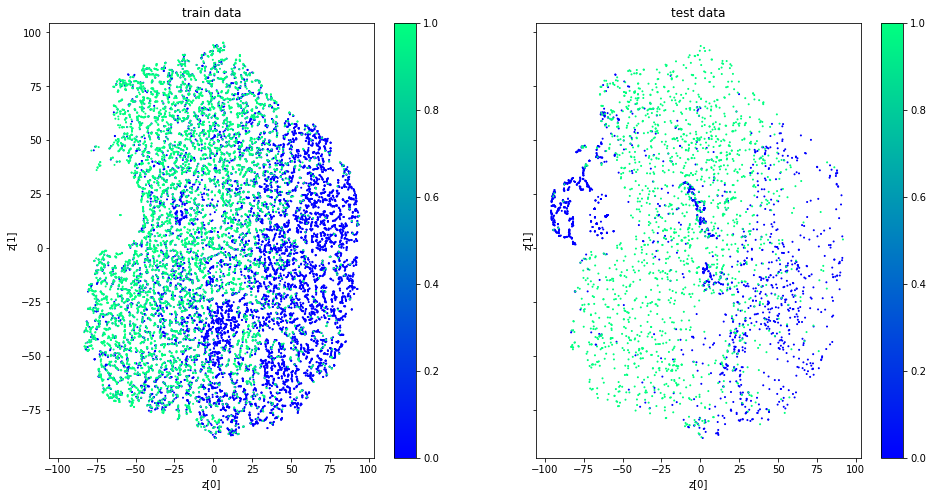

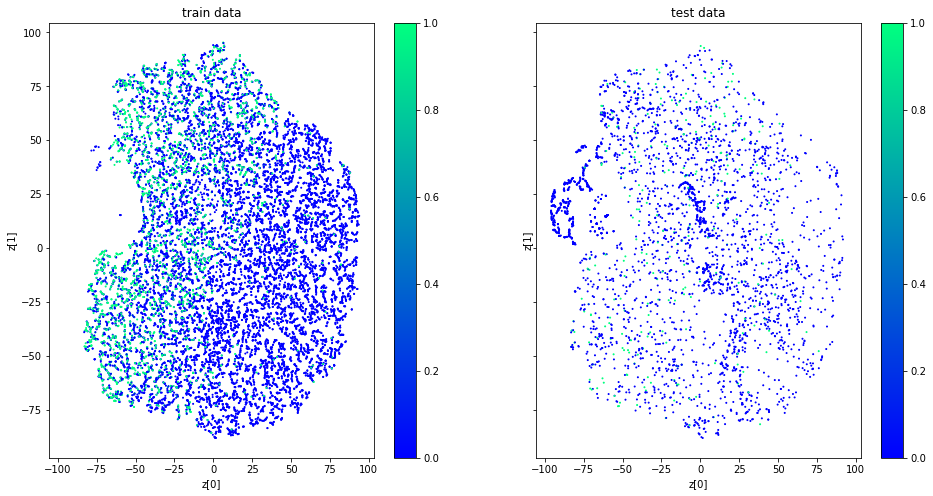

In [171]:
from sklearn.manifold import TSNE
def plot_label_clusters2( z_mean,labels):
    
    plt.figure(figsize=(8, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,s=2,cmap='winter') # also add size for scatter point
#     plt.scatter(z_mean[:,0],z_mean[:,1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

def plot_label_clusters3( z_train,y_train,z_test,y_test):    
    # -- SUBPLOT WITH TRAIN & TEST clusters
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8),sharex=True,sharey=True)
    marksize = 1
    
    s1 = ax1.scatter(z_train[:, 0], z_train[:, 1], c=y_train, s=marksize, cmap='winter',vmin=0, vmax=1) # also add size for scatter point

    ax1.set_title('train data'); 
    ax1.set_xlabel("z[0]"); 
    ax1.set_ylabel("z[1]");
    fig.colorbar(s1,ax=ax1); #ax2.colorbar()
    
    s2 = ax2.scatter(z_test[:, 0], z_test[:, 1], c=y_test, s=marksize, cmap='winter',vmin=0,vmax=1) # also add size for scatter point
    ax2.set_title('test data'); 
    ax2.set_xlabel("z[0]"); 
    ax2.set_ylabel("z[1]")
    fig.colorbar(s2,ax=ax2); #ax2.colorbar()



# plot_label_clusters2( z_all, y_label_norm[:,0]) # detail
# plot_label_clusters2( z_all, y_label_norm[:,1]) # coarse


# z_mean_train = z_all[len(x_test_balanced):,:]
# z_mean_test =  z_all[:len(x_test_balanced),:,]
plot_label_clusters3( z_mean_train, y_train_balanced[:,0] ,z_mean_test,y_test_balanced[:,0]) # detailed
plot_label_clusters3( z_mean_train, y_train_balanced[:,1] ,z_mean_test,y_test_balanced[:,1]) #coarse



2


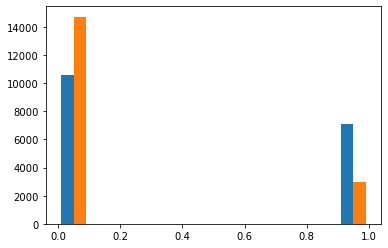

In [172]:
z_train = z_all[len(x_test_balanced):,:]
z_test =  z_all[:len(x_test_balanced),:,]
y_train = y_train_balanced
y_train[y_train > 0] = 1
y_test = y_test_balanced
y_test[y_test > 0] = 1

plt.hist(y_train)
print(len(np.unique(y_train)))

In [173]:
idx_1_detail =  y_train[:,0] == 1
# idx_1_coarse = y_train[:,1] == 1
# idx_both = y_train[:,0] == 1 and y_train[:,1] == 1
# print(idx_both)
'''
label_colors: 
0 : no label
1 : only detail label has L=1
2 : only coarse label has L=1
3 : both have L=1
'''

# label_color = np.zeros(len(y_train)) 
# label_color.shape

def labelColor(y_data):
    label_color = np.zeros(len(y_data)) 
    for i in range(len(label_color)):
        sample = y_data[i,:]
        if sample.all(): # both are 1
            label_color[i] = 3
        elif sample.any():
            if sample[0]:
                label_color[i] = 1 
            elif sample[1]:
                label_color[i] = 2
        else: # neither are 1
            label_color[i] = 0;
    return label_color

label_train = labelColor(y_train)
label_test = labelColor(y_test)

In [174]:
label_train

array([0., 0., 0., ..., 1., 1., 1.])

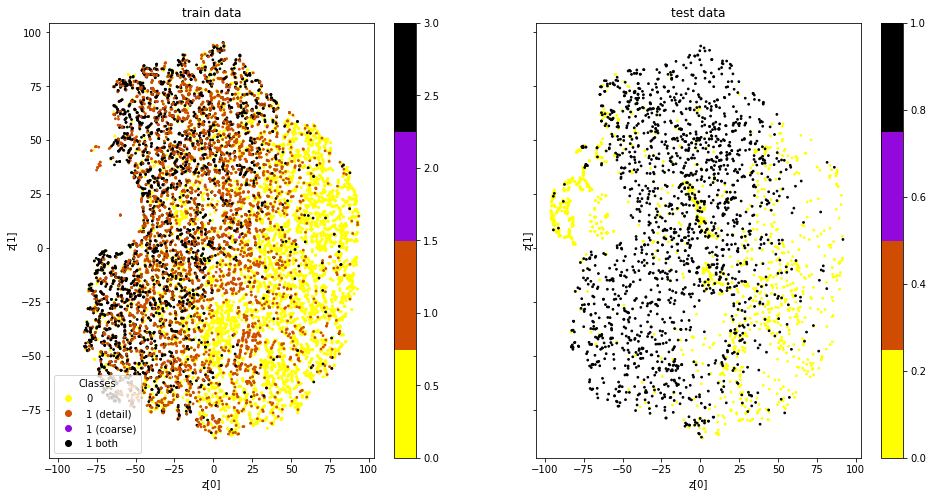

In [175]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8),sharex=True,sharey=True)
marksize = 3
cmap = cm.get_cmap('gnuplot', 4).reversed()

s11 = ax1.scatter(z_train[:, 0], z_train[:, 1], c=label_train, s=marksize, cmap=cmap,vmin=0, vmax=3) # also add size for scatter point
# s12 = ax1.scatter(z_train[:, 0], z_train[:, 1], c=y_train[:,1], s=marksize, cmap='Reds',vmin=0, vmax=1,alpha=0.7) # also add size for scatter point

ax1.set_title('train data'); 
ax1.set_xlabel("z[0]"); 
ax1.set_ylabel("z[1]");
fig.colorbar(s11,ax=ax1); #ax2.colorbar()
# fig.colorbar(s12,ax=ax1)
# legend1 = ax1.legend(*s11.legend_elements(),labels=["hoi",'doei','hoi','doei'],
#                     loc="lower left", title="Classes")
legend1 = ax1.legend(handles=s11.legend_elements()[0],labels=["0",'1 (detail)','1 (coarse)','1 both'],
                    loc="lower left", title="Classes")
# ax.add_artist(legend1)

s2 = ax2.scatter(z_test[:, 0], z_test[:, 1], c=y_test[:,0], s=marksize, cmap=cmap,vmin=0,vmax=1) # also add size for scatter point
ax2.set_title('test data'); 
ax2.set_xlabel("z[0]"); 
ax2.set_ylabel("z[1]")
fig.colorbar(s2,ax=ax2); #ax2.colorbar()

## Display grid of sampled images
For the current training-test, the sampled images are very uniform grey data

In [ ]:


def plot_predicted_tiles(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 20
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3)) #add 3rd dim
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
#             x_decoded = vae.decoder.predict(z_sample)
            x_decoded = decoder.predict(z_sample) ######################## this line has changed
#             print(x_decoded[0].shape) #[20,20,3]
            digit = x_decoded[0]#.reshape(digit_size, digit_size) # do not reshape: keep all 3 bands
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
                : # add all 3 bands
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='viridis')#"Greys_r")
    plt.show()


# plot_predicted_tiles(vae)

In [ ]:

# def plot_label_clusters(vae, data,labels):
#     # display a 2D plot of the digit classes in the latent space
# #     z_mean, _, _ = vae.encoder.predict(data)
#     z_mean, _, _ = encoder.predict(data) ###################################### this line has changed
#     plt.figure(figsize=(12, 10))
#     plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
# #     plt.scatter(z_mean[:,0],z_mean[:,1])
#     plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.show()


# # (x_train, y_train), _ = keras.datasets.mnist.load_data()
# # x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# plot_label_clusters(vae, x_train_norm, y_label_norm)